# Importing the Necessary Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk

In [4]:
from nltk.corpus import stopwords

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Number of Samples in Train and Test Datasets

In [9]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [10]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
df_test.head()

,Unnamed: 0,id,comment_text
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...
1,7,000247e83dcc1211,:Dear god this site is horrible.
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
3,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
4,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Here we see that train dataset contains **159571** samples.

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63978 entries, 0 to 63977
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    63978 non-null  int64 
 1   id            63978 non-null  object
 2   comment_text  63978 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


The test dataset contains **63978** samples.

In [16]:
cols = ['toxic',  'severe_toxic',  'obscene',  'threat',  'insult',  'identity_hate']
for col in cols:
  print(f"Fraction of {col} messages: {round(df_train[col].sum() / df_train.shape[0] * 100, 2)}%")

Fraction of toxic messages: 9.58%
Fraction of severe_toxic messages: 1.0%
Fraction of obscene messages: 5.29%
Fraction of threat messages: 0.3%
Fraction of insult messages: 4.94%
Fraction of identity_hate messages: 0.88%


We see that some of the labels appear very rarely in our dataset.

# Sample Stats

Next we define some utility functions for viewing the dataset statistics.

In [17]:
def show_percentiles(df, col, name):
  # Calculating the counts that cover 100%, 90%, 80%, ..., 10% of the rows
  percentiles = list(range(100, 0, -10))
  counts_percentiles = np.percentile(df[col], percentiles)

  # Displaying the counts at each percentile
  for percentile, count in zip(percentiles, counts_percentiles):
      print(f"{percentile}% of the rows have at most {int(count)} {name}s.")

In [18]:
def plot_hist(col, name, range=100):
  # Creating a histogram of counts for df_train
  plt.hist(df_train[col], bins=50, range=(0, range), alpha=0.5, label='Train Data')
  # Creating a histogram of counts for df_test
  plt.hist(df_test[col], bins=50, range=(0, range), alpha=0.5, label='Test Data')

  plt.xlabel(f'Number of {name}s')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {name} Counts')
  plt.legend()  # Adding a legend to distinguish between train and test data
  plt.show()

The first statistic that interests us is the number of words in every sample.

In [19]:
df_train['word_count'] = df_train['comment_text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['comment_text'].apply(lambda x: len(x.split()))

In [20]:
print("In df_train:")
show_percentiles(df_train, 'word_count', 'word')

In df_train:
100% of the rows have at most 1411 words.
90% of the rows have at most 152 words.
80% of the rows have at most 91 words.
70% of the rows have at most 63 words.
60% of the rows have at most 47 words.
50% of the rows have at most 36 words.
40% of the rows have at most 27 words.
30% of the rows have at most 20 words.
20% of the rows have at most 14 words.
10% of the rows have at most 8 words.


In [21]:
print("In df_test:")
show_percentiles(df_test, 'word_count', 'word')

In df_test:
100% of the rows have at most 2321 words.
90% of the rows have at most 143 words.
80% of the rows have at most 86 words.
70% of the rows have at most 60 words.
60% of the rows have at most 45 words.
50% of the rows have at most 34 words.
40% of the rows have at most 25 words.
30% of the rows have at most 18 words.
20% of the rows have at most 12 words.
10% of the rows have at most 7 words.


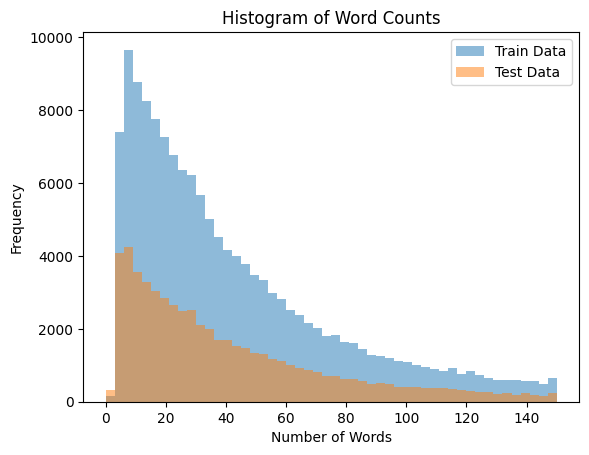

In [22]:
plot_hist('word_count', 'Word', range=150)

Next we display the distribution of character counts in different samples.

In [23]:
# Calculating text lengths and creating a new column
df_train['char_count'] = df_train['comment_text'].apply(len)
df_test['char_count'] = df_test['comment_text'].apply(len)

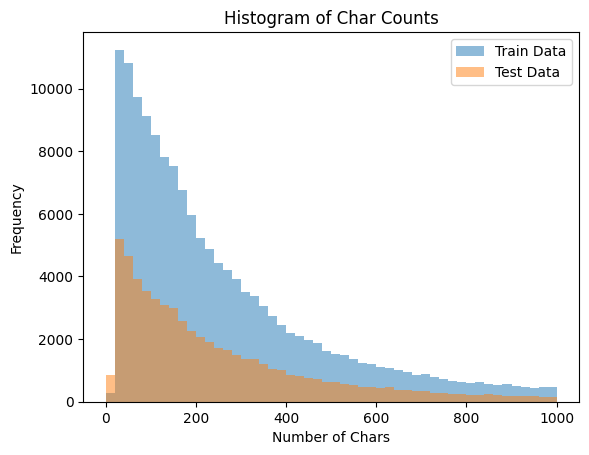

In [24]:
plot_hist('char_count', 'Char', range=1000)

Finally, we display the distribution of capital letter counts in different samples.

In [25]:
df_train['capital_letter_count'] = df_train['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df_test['capital_letter_count'] = df_test['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

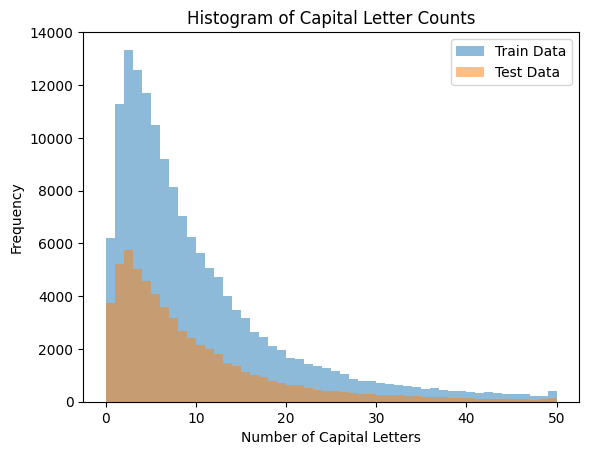

In [26]:
plot_hist('capital_letter_count', 'Capital Letter', range=50)

# Text Cleaning

In [27]:
train_texts = [text for text in df_train['comment_text']]
test_texts = [text for text in df_test['comment_text']]

In [28]:
labels_toxic = [val for val in df_train['toxic']]
labels_severe_toxic = [val for val in df_train['severe_toxic']]
labels_obscene = [val for val in df_train['obscene']]
labels_threat = [val for val in df_train['threat']]
labels_insult = [val for val in df_train['insult']]
labels_identity_hate = [val for val in df_train['identity_hate']]

Next we define a utility function to filter special symbols.

In [29]:
def remove_special_symbols(texts):
    # Defining a regular expression pattern to match special symbols
    special_symbol_pattern = r'[^A-Za-z\s]'  # This pattern matches anything that is not a letter, digit, or whitespace

    # Creating a list to store the filtered texts
    filtered_texts = []

    # Iterating through each text and removing special symbols
    for text in texts:
        filtered_text = re.sub(special_symbol_pattern, '', text)
        filtered_texts.append(filtered_text)

    return filtered_texts

In [30]:
filtered_train_texts = remove_special_symbols(train_texts)
filtered_test_texts = remove_special_symbols(test_texts)

Here is an example sentence together with its clean version.

In [31]:
test_texts[7], filtered_test_texts[7]

('|blocked]] from editing Wikipedia.   |', 'blocked from editing Wikipedia   ')

# Converting Text to Vectors

As the last preprocessing step, we convert our texts to vectors using TfidfVectorizer.

In [32]:
# Choosing max_features value
max_features = 500

# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# Fitting and transforming the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(filtered_train_texts)

# Transforming the test data
X_test_tfidf = tfidf_vectorizer.transform(filtered_test_texts)

In [33]:
X_train_tfidf.shape, X_test_tfidf.shape

((159571, 500), (63978, 500))

In [34]:
tfidf_vectorizer.vocabulary_

{'why': 471,
 'the': 410,
 'edits': 119,
 'made': 236,
 'under': 438,
 'my': 261,
 'were': 462,
 'reverted': 345,
 'they': 417,
 'just': 210,
 'on': 286,
 'some': 373,
 'after': 10,
 'at': 37,
 'new': 269,
 'and': 22,
 'please': 310,
 'dont': 112,
 'remove': 339,
 'template': 401,
 'from': 147,
 'talk': 399,
 'page': 300,
 'since': 370,
 'im': 188,
 'now': 279,
 'he': 171,
 'this': 421,
 'with': 477,
 'thanks': 407,
 'utc': 448,
 'hey': 176,
 'man': 241,
 'really': 330,
 'not': 273,
 'trying': 436,
 'to': 430,
 'edit': 115,
 'war': 454,
 'its': 208,
 'that': 408,
 'is': 203,
 'removing': 341,
 'relevant': 337,
 'information': 197,
 'me': 247,
 'through': 426,
 'instead': 198,
 'of': 281,
 'seems': 359,
 'care': 66,
 'more': 256,
 'about': 1,
 'than': 405,
 'info': 196,
 'cant': 65,
 'make': 238,
 'any': 25,
 'real': 329,
 'if': 186,
 'section': 356,
 'should': 366,
 'be': 44,
 'later': 217,
 'or': 291,
 'think': 420,
 'references': 335,
 'may': 245,
 'need': 265,
 'so': 372,
 'are': 30

In [ ]:
tfidf_vectorizer.stop_words_

In [35]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()